<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

from random import randint
from urllib.request import urlopen

from numpy import asarray

In [5]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4705 entries, 0 to 4704
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4705 non-null   int64  
 1   sku                   4705 non-null   int64  
 2   short_description     4640 non-null   object 
 3   price                 4705 non-null   int64  
 4   discount              4705 non-null   int64  
 5   discount_rate         4705 non-null   int64  
 6   rating_average        4705 non-null   float64
 7   review_count          4705 non-null   int64  
 8   order_count           4705 non-null   int64  
 9   favourite_count       4705 non-null   int64  
 10  thumbnail_url         4705 non-null   object 
 11  categories            4705 non-null   object 
 12  liked                 4705 non-null   bool   
 13  rating_summary        4705 non-null   object 
 14  brand                 4705 non-null   object 
 15  current_seller       

In [7]:
df.head()

,id,sku,short_description,price,discount,discount_rate,rating_average,review_count,order_count,favourite_count,thumbnail_url,categories,liked,rating_summary,brand,current_seller,other_sellers,configurable_options,extra_feature,cloth_type
0,0,4777164499549,\n \n- Loại : Quần Thể Thao Đen.\n- Kiểu Dáng ...,99000,101000,51,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 36387, ""sku"": ""5716562721707"", ""store_i...","[{""id"": 134556, ""name"": ""Mualayeushop"", ""link""...","[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],top_t-shirt_sweatshirt shoe pants
1,1,2931572867679,\nÁo Len Nam Dày Bs33 được may từ chất liệu le...,400000,0,0,0.0,0,0,1,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 2, ""name"": ""Root"", ""is_leaf"": false}",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 10025, ""sku"": ""4689826428364"", ""store_i...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[],sweater
2,2,6427102533481,\n \n- Loại : Quần Âu Thêu Vương Miện\n- Kiểu ...,159000,141000,47,4.5,14,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 9674, ""sku"": ""5288509925221"", ""store_id...",[],"[{""code"": ""option1"", ""name"": ""Size"", ""position...",[],watch shoe shirt_blouse pants
3,3,1590440568400,"Khách vui lòng xem kĩ số đo sản phẩm, hình thậ...",109000,81000,43,4.2,15,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 22226, ""sku"": ""1822886614091"", ""store_i...",[],NaN,[],belt dress bag_wallet shoe
4,4,8690273838961,"sét áo dài cách tân mới chât đẹpsize S,M,Lset ...",290000,160000,36,3.0,3,0,5,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}",NaN,[],"[{""code"": ""option1"", ""name"": ""szie"", ""position...",[],bag_wallet dress shoe


In [8]:
total_images = df.thumbnail_url.notna().sum()
total_images

4705

show random image and label 

In [9]:
from random import randint
from urllib.request import urlopen

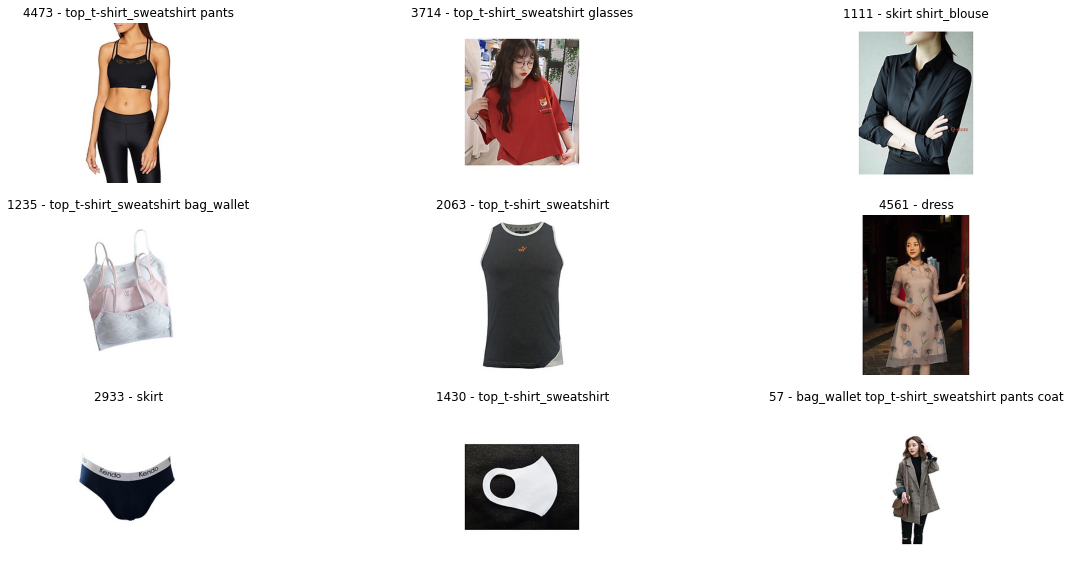

In [13]:
# plot random 9 image
fig = plt.figure(figsize=(20,10))
for i in range(0,9):
  ax = plt.subplot(3,3,i+1)
  _i = randint(0,total_images)
  img = Image.open(urlopen(df.thumbnail_url[_i]))
  ax = plt.imshow(img)
  plt.title(f"{_i} - {df.cloth_type[_i]}")
  plt.axis("off")

In [ ]:
# 1430

Create Mapping

In [14]:
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]

In [15]:
all_label = [label for sub in labels for label in sub]

In [16]:
labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

In [17]:
label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}

Whichs are the tops used label?

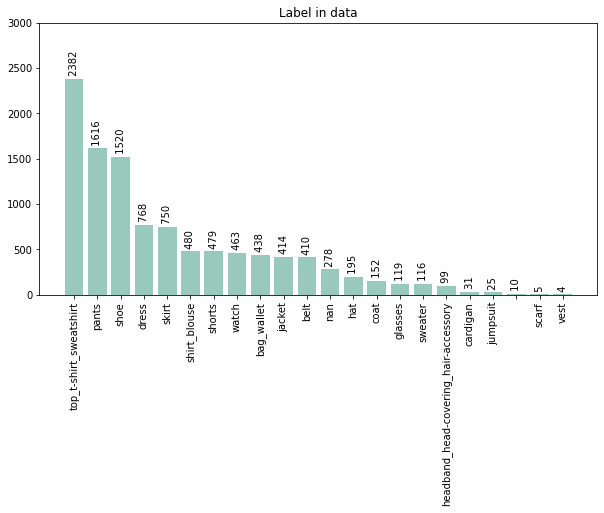

In [18]:
fig = plt.figure(figsize=(10,5))
plt.bar(label_name, label_freq, color="#99C8BC")
plt.title("Label in data")
plt.xticks(rotation=90)
for i, (tag,count) in enumerate(labels_count.most_common()):
  plt.text(i, count, f" {count} ", rotation=90, ha="center", va="bottom", color="black")
plt.ylim(0,3000);


Create a one hot encoding for one list of tags

In [19]:
from numpy import asarray

In [20]:
def one_hot_encoder(tags, mapping):
  # create empty vector
  encoding = np.zeros(len(label_map), dtype="uint")
  # mark 1 for each tag in the vector
  for tag in tags:
    encoding[label_map[tag]] = 1
  return encoding

In [21]:
def load_dataset(images_url, labels, label_map):
  # images,  targets = list(), list()
  images = []
  targets = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    # turn image in to array
    img = asarray(img)
    tags = labels[i]
    target = one_hot_encoder(tags, label_map)

    if img.shape == (280,280,3):
      images.append(img)
      targets.append(target)
    else: print(f"the image[{i}] shape is {img.shape}")

  X = asarray(images, dtype="uint8")
  y = asarray(targets, dtype="uint8")

  return X, y



In [22]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [ ]:
X, y = load_dataset(df.thumbnail_url[:1000], labels[:1000], label_map)

save the array:

In [ ]:
np.savez_compressed("/content/drive/MyDrive/01_Personal/99_temp/sss_data_100.npz", X, y)

In [ ]:
X.shape

(1000, 280, 280, 3)

load array:

In [23]:
data = np.load("/content/drive/MyDrive/01_Personal/99_temp/sss_data_100.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (1000, 280, 280, 3) (1000, 22)


In [35]:
# load full data
data = np.load("/content/drive/MyDrive/01_Personal/99_temp/sss_data_full.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4700, 280, 280, 3) (4700, 22)


# How to evaluate model

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [38]:
train_yhat = asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])

In [39]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

In [40]:
fbeta_score(y_train, train_yhat, beta=2, average='samples')

0.34302553465099156

In [41]:
f1_score(y_train, train_yhat, average='samples')

0.1823008566859569

In [42]:
X_train.shape

(3149, 280, 280, 3)

# Baseline model

In [43]:
import sys
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

In [44]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [45]:
fbeta(y_train, train_yhat, beta=2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.3430255059671137>

In [46]:
def define_model(in_shape=(280,280,3), out_shape=22):
  model = Sequential()
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(32,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(64,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(Conv2D(128,
                   (3,3), 
                   activation="relu", 
                   kernel_initializer='he_uniform',
                   padding="same",
                   input_shape=in_shape
                   )
  )
  model.add(MaxPool2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu", kernel_initializer='he_uniform'))
  model.add(Dense(out_shape, activation="sigmoid"))

  # Compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

  return model

In [47]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [48]:
datagen = ImageDataGenerator(rescale=1.0/225.0)
train_it = datagen.flow(X_train, y_train, batch_size=128)
test_it = datagen.flow(X_test, y_test, batch_size=128)
model = define_model()

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 280, 280, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 280, 280, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 140, 140, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 140, 140, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 140, 140, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 70, 70, 128)      

In [50]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=50)

Epoch 1/50
25/25 [==============================] - 107s 2s/step - loss: 0.3052 - fbeta: 0.1947 - val_loss: 0.2610 - val_fbeta: 0.0765
Epoch 2/50
25/25 [==============================] - 43s 2s/step - loss: 0.2556 - fbeta: 0.1848 - val_loss: 0.2558 - val_fbeta: 0.3167
Epoch 3/50
25/25 [==============================] - 43s 2s/step - loss: 0.2490 - fbeta: 0.2425 - val_loss: 0.2486 - val_fbeta: 0.2434
Epoch 4/50
25/25 [==============================] - 43s 2s/step - loss: 0.2398 - fbeta: 0.2832 - val_loss: 0.2395 - val_fbeta: 0.3448
Epoch 5/50
25/25 [==============================] - 43s 2s/step - loss: 0.2318 - fbeta: 0.3327 - val_loss: 0.2366 - val_fbeta: 0.3902
Epoch 6/50
25/25 [==============================] - 43s 2s/step - loss: 0.2251 - fbeta: 0.3717 - val_loss: 0.2300 - val_fbeta: 0.2579
Epoch 7/50
25/25 [==============================] - 43s 2s/step - loss: 0.2193 - fbeta: 0.3545 - val_loss: 0.2265 - val_fbeta: 0.3887
Epoch 8/50
25/25 [==============================] - 48s 2s/st

In [51]:
loss, fbeta = model.evaluate(test_it, steps=len(test_it))

13/13 [==============================] - 6s 406ms/step - loss: 0.7188 - fbeta: 0.4653


In [52]:
print(f"> loss = {loss:.3f}, f1-mean = {fbeta:.3f}")

> loss = 0.719, f1-mean = 0.465


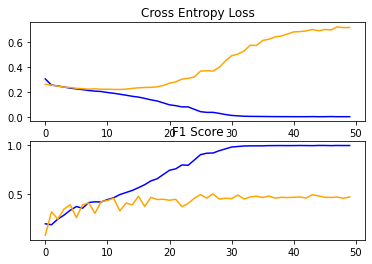

In [53]:
summarize_diagnostics(history)

In [61]:
model.save_weights('/content/drive/MyDrive/01_Personal/99_temp/sss_models/firstweight/firstweight')

In [62]:
model.load_weights('/content/drive/MyDrive/01_Personal/99_temp/sss_models/firstweight/firstweight')

# Prediction

In [63]:
train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/test.csv"
df1 = pd.read_csv(train_url)

In [64]:
df1.head()

,id,sku,short_description,price,discount,discount_rate,rating_average,review_count,order_count,favourite_count,thumbnail_url,categories,liked,rating_summary,brand,current_seller,other_sellers,configurable_options,extra_feature
0,4705,9057406812349,\nÁo Khoác Hoodie Tay Phối Màu 450\nMã sản phẩ...,340000,50000,13,0.0,0,0,14,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 6068, ""sku"": ""1538990418318"", ""store_id...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[]
1,4706,6988568668365,Chân váy voan xoè cực hot luôn nè.\nMix với áo...,129000,71000,36,0.0,0,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 111461, ""name"": ""OEM"", ""slug"": ""oem""}","{""id"": 67371, ""sku"": ""6051137197846"", ""store_i...",[],"[{""code"": ""option1"", ""name"": ""Kích cỡ"", ""posit...",[]
2,4707,1125874521075,Hoodie In Ảnh EXO Don't Mess Up My Tempo Exo\n...,199000,31000,13,0.0,0,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 201603, ""name"": ""WinBeen"", ""slug"": ""win...","{""id"": 6852, ""sku"": ""9332768523523"", ""store_id...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[]
3,4708,2341269794193,\nQuần T&acirc;y Nam Titishop&nbsp;được may từ...,420000,0,0,0.0,0,0,0,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 2, ""name"": ""Root"", ""is_leaf"": false}",False,[],"{""id"": 144467, ""name"": ""Titishop"", ""slug"": ""ti...","{""id"": 476, ""sku"": ""1487203243530"", ""store_id""...",[],"[{""code"": ""option1"", ""name"": ""Kích cỡ"", ""posit...",[]
4,4709,9122543089470,\nÁo cardigan len nữ thêu hoa tay loe LHA fash...,164000,26000,14,5.0,1,0,2,https://salt.tikicdn.com/cache/280x280/ts/prod...,"{""id"": 914, ""name"": ""Thời Trang"", ""is_leaf"": f...",False,[],"{""id"": 501413, ""name"": ""LAHstore"", ""slug"": ""la...","{""id"": 132473, ""sku"": ""9155952581785"", ""store_...",[],"[{""code"": ""option1"", ""name"": ""Màu"", ""position""...",[]


In [65]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1505 entries, 0 to 1504
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1505 non-null   int64  
 1   sku                   1505 non-null   int64  
 2   short_description     1489 non-null   object 
 3   price                 1505 non-null   int64  
 4   discount              1505 non-null   int64  
 5   discount_rate         1505 non-null   int64  
 6   rating_average        1505 non-null   float64
 7   review_count          1505 non-null   int64  
 8   order_count           1505 non-null   int64  
 9   favourite_count       1505 non-null   int64  
 10  thumbnail_url         1505 non-null   object 
 11  categories            1505 non-null   object 
 12  liked                 1505 non-null   bool   
 13  rating_summary        1505 non-null   object 
 14  brand                 1505 non-null   object 
 15  current_seller       

In [66]:
def load_testset(images_url):
  # images,  targets = list(), list()
  images = []
  for i in range(0,len(images_url)):
    # load_img
    img = Image.open(urlopen(images_url[i]))
    img.convert("RGB")
    # turn image in to array
    img = asarray(img)[:,:,:3]

    images.append(img)

  X_test = asarray(images, dtype="uint8")
  return X_test

In [ ]:
data_test = load_testset(df1.thumbnail_url)

In [ ]:
np.savez_compressed("/content/drive/MyDrive/01_Personal/99_temp/test_data.npz", data_test)

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/01_Personal/99_temp/sss_models/first.h5')

In [55]:
data = np.load("/content/drive/MyDrive/01_Personal/99_temp/test_data.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [79]:
predictions = model.predict(test_data)

In [80]:
predictions.shape

(1505, 22)

In [90]:
def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

In [97]:
prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]

In [104]:
prediction_tags
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

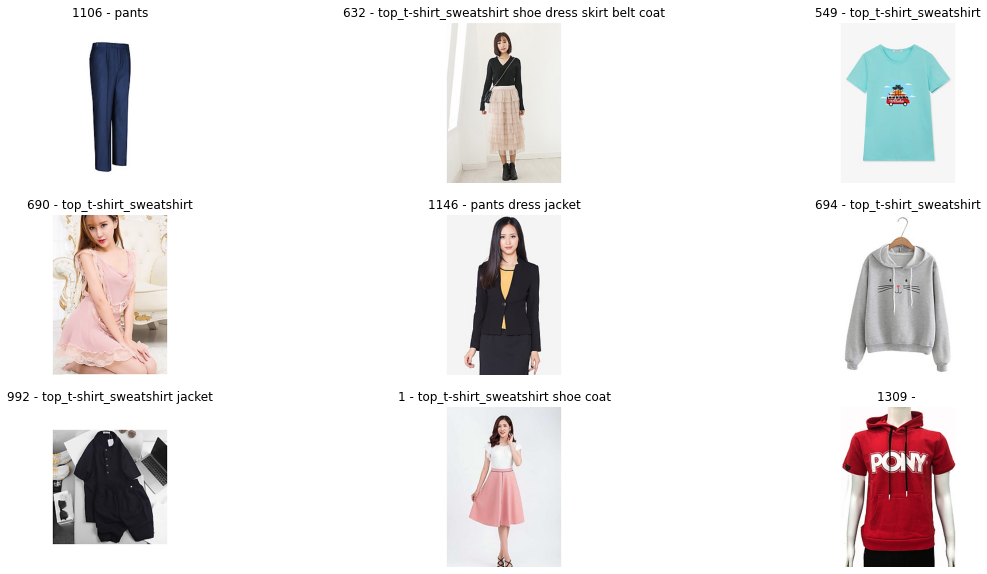

In [113]:
# plot random 9 image
fig = plt.figure(figsize=(20,10))
for i in range(0,9):
  ax = plt.subplot(3,3,i+1)
  _i = randint(0,len(test_data))
  ax = plt.imshow(test_data[_i])
  plt.title(f"{_i} - {prediction_tags[_i]}")
  plt.axis("off")

In [110]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

In [112]:
submission.head(20)

,id,cloth_type
0,4705,top_t-shirt_sweatshirt
1,4706,top_t-shirt_sweatshirt shoe coat
2,4707,top_t-shirt_sweatshirt
3,4708,pants shoe shirt_blouse bag_wallet jacket belt
4,4709,
5,4710,dress
6,4711,top_t-shirt_sweatshirt
7,4712,
8,4713,top_t-shirt_sweatshirt jacket
9,4714,top_t-shirt_sweatshirt pants shoe
